In [1]:
import os
import glob
import random
from time import time
import numpy as np
import h5py
import matplotlib.pyplot as plt

from numba import cuda, jit

from dask import delayed, compute
from dask.diagnostics import ProgressBar
from tqdm import tqdm

from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

import rasterio as rio

import xarray as xr
import rioxarray

t0 = time()

In [2]:
# change these as fitting
site = 'TALL'

# these two paths can, but do not have to be, the same
source_path = os.path.join('/media', 'storage', 'NEON')
destination_path = os.path.join('/media', 'data', 'NEON')

In [3]:
# paths
data_dir = os.path.join(source_path, site)
out_dir = os.path.join(destination_path, site)

hyper_path = os.path.join(
                data_dir, 
                'hyperspectral',
                'DP3.30006.001',
                'neon-aop-products')

# check to make sure there is hyperspectral for the site
if not os.path.isdir(hyper_path):
    a = f'There appears to be no hyperspectral data for {site}. '
    b = f'{hyper_path} is not a directory.'
    msg = a + b
    raise Exception(msg)

# get the years (they are directories in hyper_path)
years = os.listdir(hyper_path)

In [4]:
# make a dict with paths to all files for each year
files_dict = {}

for year in years:

    # get the rest of the path
    globstring = os.path.join(hyper_path,
    year,
    'FullSite',
    'D08',
    f'{year}_{site}_[0-9]',
    'L3',
    'Spectrometer',
    'Reflectance',
    f'NEON_D08_{site}_DP3_*.h5')


    # find the names of the hyperspectral cubes
    files_dict[year] =  glob.glob(globstring)


In [5]:
def band_list():
    '''excludes bands with H2O or CO2 absorption'''
    good_bands = np.hstack([
        np.arange(0, 188 + 1),
        np.arange(211, 269 + 1),
        np.arange(316, 425 + 1)
    ])
    
    return good_bands


In [6]:
@delayed
def sample_from_file(fname, size):
    '''samples from file'''
    
    # open the file
    f = h5py.File(fname, 'r')

    # get the within reflectance as np array
    refl_array = np.array(np.rot90(f[site]['Reflectance']['Reflectance_Data']))

    # drop bad bands from refl_array
    refl_array = refl_array[:, :, band_list()]

    # get shape of wavelenght dimension
    wl = refl_array.shape[2]

    # reshape
    flat_refl = refl_array.reshape(-1, wl)

    # drop nulls
    flat_refl = flat_refl[
    (~np.any(flat_refl == -9999, axis=1)) &
    (~np.any(np.isnan(flat_refl), axis=1))]

    # get random sample indices
    random.seed(3)
    sample_idx = random.sample(range(flat_refl.shape[0]), int(flat_refl.shape[0] * size))

    # return sample
    return flat_refl[sample_idx, :]
    

def sample_from_all(files, size):
    '''
    Returns a np array of samples of shape (N, wl) where N is
    the number of samples and wl is the length of the wavelength
    dimension.
    
    args:
        files    - list of full paths to netcdf4 files to be used. 
        size     - fraction of data to be used.
    '''
    # empty list for samples
    samples = []
    
    for fname in files:
        samples.append(sample_from_file(fname, size))
        
    with ProgressBar():
        sample = np.vstack(compute(*samples))
        
    return sample


def plot_pca_var(pca):
    '''plots explained variance by PCA component'''
    
    # make fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, 359),
             pca.explained_variance_ratio_.cumsum(),
             marker='o',
             linestyle='--');
    
    # details
    plt.title('Explained Variance by Number of Components');
    plt.xlabel('Components');
    plt.ylabel('Cumulative explained Var');
    plt.xlim(0, 20);
    plt.show()
    
    
def kmeans_wcss(n_components, scaled_refl, max_n_clusters=20):
    '''
    Returns a list of wcss values for different n_clusters values
    after performing PCA using n_components.
    args:
        n_components   - number of components to be kept in PCA.
        scaled_refl    - scaled values on which to perform PCA and
                         clustering.
        max_n_clusters - max number of clusters to try default 20.
    '''
    # use n components for pca
    pca = PCA(n_components=n_components)

    # fit
    pca.fit(scaled_refl)

    # get component scores
    scores_pca = pca.transform(scaled_refl)

    # empty list for witih cluster sum of squares
    wcss = []

    # now try out some differnt cluster numbers
    print(f'Out of {max_n_clusters} trials working on:')

    for n in range(1, max_n_clusters + 1):
        
        print(f'\b\b{n}', end="")
        
        kmeans =  KMeans(n_clusters=n, init='k-means++', random_state=42)
        kmeans.fit(scores_pca)
        wcss.append(kmeans.inertia_)

    print('\ndone!')
    
    return wcss, pca


def plot_wcss(wcss):
    '''plots wcss vs n_clusters'''
    
    # fig
    plt.figure(figsize=(10, 4));

    # plot
    plt.plot(range(1, len(wcss) + 1),
             wcss,
             marker='o',
             linestyle='--');

    # details
    plt.title('Kmeans with PCA WCSS');
    plt.xlabel('WCSS');
    plt.ylabel('Number of Clusters');

In [7]:
# see what years we have data for
print(years)

['2021', '2019', '2018']


## 2018 ##

In [8]:
# get year's files
year = '2018'
files = files_dict[year]

# make path for pca tifs, ensure exists
pca_house = os.path.join(out_dir, 'pca')
os.makedirs(os.path.join(pca_house, year), exist_ok=True)

# sample 0.2% of pixels in data for year
size = 1 / 500
sample = sample_from_all(files, size)

[########################################] | 100% Completed |  4min 28.0s


In [9]:
# make an array, change dtype for memory 
sample = np.array(sample, dtype=np.float16)

# scale the data
scaler = StandardScaler().fit(sample)
scaled = scaler.transform(sample)

# instantiate the PCA model
pca = PCA()

# fit the pca model
pca.fit(scaled)

# try to free up sume memory
del sample

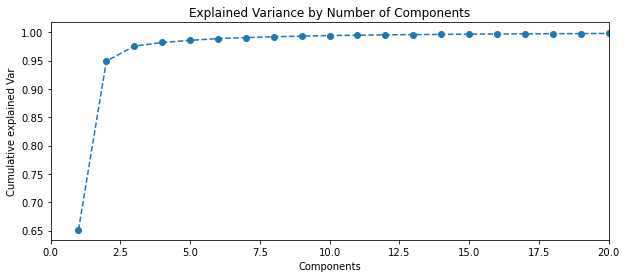

In [10]:
plot_pca_var(pca)

The first 2 components capture over 95% of the variance, so we will use 2.

In [11]:
# 2 components as discussed above
n_components = 2

# get wcss for different n_clusters and train the pca for n_components
wcss, pca = kmeans_wcss(n_components, scaled, max_n_clusters=10)

Out of 10 trials working on:
10
done!


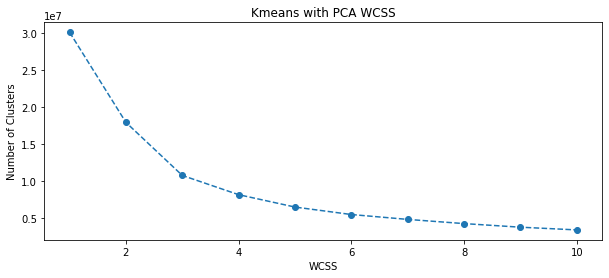

In [12]:
plot_wcss(wcss)

Using the elbow method, we vary number of clusters  calculating WCSS ( Within-Cluster Sum of Square ) for each. WCSS is the sum of squared distance between each point and the centroid in a cluster. The graph inflects at 3. Now we will make the actual data files using k=2 and n=3.

 

In [13]:
# 3 clusters as discussed above
n_clusters = 3

In [14]:
def read_h5_do_pca(fname, scaler, pca):
    '''reads'''  

    # open the file
    f = h5py.File(fname, 'r')
    
    # seperate out reflectance
    refl = f[site]['Reflectance']

    # get no data value
    no_data_value = refl['Reflectance_Data'].attrs['Data_Ignore_Value']
    
    # get the actual data within reflectance as array
    refl_array = np.array(np.rot90(refl['Reflectance_Data'], k=3), dtype=np.float16)
    
    # drop bad bands from refl_array
    refl_array = refl_array[:, :, band_list()]
    
    # get wavelength info
    wavelengths = np.array(refl['Metadata']['Spectral_Data']['Wavelength'])
    
    # drop bad bands from wavelength
    wavelengths = wavelengths[band_list()]
    
    # get  dimensions of array
    x  = refl_array.shape[0]
    y  = refl_array.shape[1]
    wl = refl_array.shape[2]

    # reshape
    flat_refl = refl_array.reshape(-1, wl)
    
    # make sure there are no nans
    flat_refl[np.isnan(flat_refl)] = no_data_value
    
    # before we drop no-datas get their indices
    null_idx = np.argwhere(np.any(flat_refl == no_data_value, axis=1)).flatten()

    # pick arbitray valid index
    good_idx = np.argwhere(~np.any(flat_refl == no_data_value, axis=1)).flatten()[25]
    
    # fill no-datas with a vaule within normal range if need be (they will be returned to na data val in output)
    if null_idx.any():
        #flat_refl = flat_refl[np.argwhere(~np.any(flat_refl == no_data_value, axis=1)).flatten()]
        flat_refl[null_idx] = flat_refl[good_idx]

    # scale with previously fit scaler
    scaled = scaler.transform(flat_refl)
    
    # get component scores
    scores_pca = pca.transform(scaled)
    
    # put no-data values back in if need be
    if null_idx.any():
        #scores_pca = np.insert(scores_pca, null_idx, [no_data_value] * scores_pca.shape[1], axis=0)
        scores_pca[null_idx, :] = [no_data_value] * scores_pca.shape[1]

    # reshape to original tile x, y
    scores_pca = scores_pca.reshape(x, y, n_components)
    
    # close hdf
    #f.close()
    
    return scores_pca, refl

    
def tiffize_and_xarray(arr, refl, out_file):
    '''
    Writes tiff from array.
    
    args:
        arr      - array to be written as tiff
        refl     - reflectance metadata from h5
        out_file - filename of tiff to write
    '''
    # bag crs as epsg
    epsg = refl['Metadata']['Coordinate_System']['EPSG Code'][()].decode("utf-8")
    epsg = f'EPSG:{epsg}'
    
    # bag other crs info
    crs_info = refl['Metadata']['Coordinate_System']['Map_Info'][()].decode("utf-8").split(',')


    # get corners and x, y resolution
    xmin = float(crs_info[3])
    ymax = float(crs_info[4])
    xres = float(crs_info[5])
    yres = float(crs_info[6])
    xmax = xmin + (arr.shape[1] * xres) 
    ymin = ymax - (arr.shape[0] * yres)

    # create array of x center pixel locations in utm coords
    x = np.linspace(xmin, xmax, arr.shape[1], endpoint=False)
    x = x + xres * 0.5

    # create array of y center pixel locations in utm coords
    y = np.linspace(ymin, ymax, arr.shape[0], endpoint=False)
    y = y + yres * 0.5

    # make dataset
    d_all = xr.DataArray(arr, dims=['x', 'y', 'components'], coords={'x':x, 'y':y, 'components': range(arr.shape[2])})
    d_all.name = 'pca'
    d_all = d_all.to_dataset()
    
    # assign crs and spatial dims
    d_all.rio.write_crs(epsg, inplace=True)

    # attributes
    no_data_value = refl['Reflectance_Data'].attrs['Data_Ignore_Value']
    d_all.attrs = {
                    'no_data_value': no_data_value,
                    'epsg': epsg,
                    'crs' : crs_info
                  }

    # write the labels to geotiff
    d_all.pca.transpose('components', 'y', 'x').rio.to_raster(out_file)
    
    return d_all
    
    
    

In [15]:
print(f'Of {len(files)} on:')

# list for xarrays to merge later
xarrays = []

for i, f in tqdm(enumerate(files)):
    
    base = os.path.basename(f).split('.')[0].split('_')
    base = '_'.join([base[2], base[4], base[5]])

    scores_pca, refl = read_h5_do_pca(f, scaler, pca)                            

    # make fname
    tiff = os.path.join(pca_house, year, f'{base}_pca.tiff')

    xarrays.append(tiffize_and_xarray(scores_pca, refl, tiff))

    

Of 49 on:


49it [15:54, 19.49s/it]


In [16]:
mosaic = xr.combine_by_coords(xarrays, combine_attrs='override')
no_data_value = mosaic.attrs['no_data_value']

In [17]:
# get the nice unified pca array
pca_arr = mosaic.pca.data

# determine number of pca compnents in use
comps = mosaic.components.data.shape[0]

# flatten the pca img
flat_pca = pca_arr.reshape(-1, comps)

# before we drop no-datas get their indices
null_idx = np.argwhere(np.any(flat_pca == no_data_value, axis=1)).flatten()

# pick arbitray valid index
good_idx = np.argwhere(~np.any(flat_pca == no_data_value, axis=1)).flatten()[25]

# drop no-datas
if null_idx.any():
    flat_pca[null_idx] = flat_pca[good_idx]

# cluster
kmeans =  KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(flat_pca)

# get labels
labels = kmeans.labels_

# add the labels to the xarray
mosaic['kmeans_label'] = xr.DataArray(labels.reshape(pca_arr.shape[0], pca_arr.shape[1]), dims=['x', 'y'])

In [18]:
# ensure directory for tiffs exists and make path
# ensure directory for mosaics exists and make path
mosaic_house = os.path.join(out_dir, 'mosaic')
os.makedirs(os.path.join(mosaic_house, year), exist_ok=True)

# make fname
tiff = os.path.join(mosaic_house, year, f'{site}_{year}_kmeans_mosaic.tiff')

# write the labels to geotiff
mosaic.kmeans_label.transpose('y', 'x').rio.to_raster(tiff, dtype=np.int8)

In [19]:
# make fname
tiff = os.path.join(mosaic_house, year, f'{site}_{year}_pca_mosaic.tiff')

# write the labels to geotiff
mosaic.pca.transpose('components', 'y', 'x').rio.to_raster(tiff)

In [20]:
ncdf = os.path.join(mosaic_house, year, f'{site}_{year}_mosaic.nc')
mosaic.to_netcdf(ncdf)

## 2019 ##

We will use the same n and k values determined above.

In [21]:
years

['2021', '2019', '2018']

In [22]:
# get year's files
year = '2019'
files = files_dict[year]

# make path for pca tifs, ensure exists
pca_house = os.path.join(out_dir, 'pca')
os.makedirs(os.path.join(pca_house, year), exist_ok=True)

In [26]:
print(f'Of {len(files)} on:')

# list for xarrays to merge later
xarrays = []

for i, f in tqdm(enumerate(files)):
    
    base = os.path.basename(f).split('.')[0].split('_')
    base = '_'.join([base[2], base[4], base[5]])

    scores_pca, refl = read_h5_do_pca(f, scaler, pca)                            

    # make fname
    tiff = os.path.join(pca_house, year, f'{base}_pca.tiff')

    xarrays.append(tiffize_and_xarray(scores_pca, refl, tiff))

    

Of 49 on:


49it [18:35, 22.77s/it]


In [27]:
mosaic = xr.combine_by_coords(xarrays, combine_attrs='override')
no_data_value = mosaic.attrs['no_data_value']

In [28]:
# get the nice unified pca array
pca_arr = mosaic.pca.data

# determine number of pca compnents in use
comps = mosaic.components.data.shape[0]

# flatten the pca img
flat_pca = pca_arr.reshape(-1, comps)

# before we drop no-datas get their indices
null_idx = np.argwhere(np.any(flat_pca == no_data_value, axis=1)).flatten()

# pick arbitray valid index
good_idx = np.argwhere(~np.any(flat_pca == no_data_value, axis=1)).flatten()[25]

# drop no-datas
if null_idx.any():
    flat_pca[null_idx] = flat_pca[good_idx]

# cluster
kmeans =  KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(flat_pca)

# get labels
labels = kmeans.labels_

# add the labels to the xarray
mosaic['kmeans_label'] = xr.DataArray(labels.reshape(pca_arr.shape[0], pca_arr.shape[1]), dims=['x', 'y'])

In [29]:
# ensure directory for tiffs exists and make path
# ensure directory for mosaics exists and make path
mosaic_house = os.path.join(out_dir, 'mosaic')
os.makedirs(os.path.join(mosaic_house, year), exist_ok=True)

# make fname
tiff = os.path.join(mosaic_house, year, f'{site}_{year}_kmeans_mosaic.tiff')

# write the labels to geotiff
mosaic.kmeans_label.transpose('y', 'x').rio.to_raster(tiff, dtype=np.int8)

In [30]:
# make fname
tiff = os.path.join(mosaic_house, year, f'{site}_{year}_pca_mosaic.tiff')

# write the labels to geotiff
mosaic.pca.transpose('components', 'y', 'x').rio.to_raster(tiff)

In [31]:
ncdf = os.path.join(mosaic_house, year, f'{site}_{year}_mosaic.nc')
mosaic.to_netcdf(ncdf)

## 2021 ##

We will use the same n and k values determined above.

In [32]:
years

['2021', '2019', '2018']

In [33]:
# get year's files
year = '2021'
files = files_dict[year]

# make path for pca tifs, ensure exists
pca_house = os.path.join(out_dir, 'pca')
os.makedirs(os.path.join(pca_house, year), exist_ok=True)

In [34]:
print(f'Of {len(files)} on:')

# list for xarrays to merge later
xarrays = []

for i, f in tqdm(enumerate(files)):
    
    base = os.path.basename(f).split('.')[0].split('_')
    base = '_'.join([base[2], base[4], base[5]])

    scores_pca, refl = read_h5_do_pca(f, scaler, pca)                            

    # make fname
    tiff = os.path.join(pca_house, year, f'{base}_pca.tiff')

    xarrays.append(tiffize_and_xarray(scores_pca, refl, tiff))

    

Of 49 on:


49it [18:27, 22.61s/it]


In [35]:
mosaic = xr.combine_by_coords(xarrays, combine_attrs='override')
no_data_value = mosaic.attrs['no_data_value']

In [36]:
# get the nice unified pca array
pca_arr = mosaic.pca.data

# determine number of pca compnents in use
comps = mosaic.components.data.shape[0]

# flatten the pca img
flat_pca = pca_arr.reshape(-1, comps)

# before we drop no-datas get their indices
null_idx = np.argwhere(np.any(flat_pca == no_data_value, axis=1)).flatten()

# pick arbitray valid index
good_idx = np.argwhere(~np.any(flat_pca == no_data_value, axis=1)).flatten()[25]

# drop no-datas
if null_idx.any():
    flat_pca[null_idx] = flat_pca[good_idx]

# cluster
kmeans =  KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(flat_pca)

# get labels
labels = kmeans.labels_

# add the labels to the xarray
mosaic['kmeans_label'] = xr.DataArray(labels.reshape(pca_arr.shape[0], pca_arr.shape[1]), dims=['x', 'y'])

In [37]:
# ensure directory for tiffs exists and make path
# ensure directory for mosaics exists and make path
mosaic_house = os.path.join(out_dir, 'mosaic')
os.makedirs(os.path.join(mosaic_house, year), exist_ok=True)

# make fname
tiff = os.path.join(mosaic_house, year, f'{site}_{year}_kmeans_mosaic.tiff')

# write the labels to geotiff
mosaic.kmeans_label.transpose('y', 'x').rio.to_raster(tiff, dtype=np.int8)

In [38]:
# make fname
tiff = os.path.join(mosaic_house, year, f'{site}_{year}_pca_mosaic.tiff')

# write the labels to geotiff
mosaic.pca.transpose('components', 'y', 'x').rio.to_raster(tiff)

In [39]:
ncdf = os.path.join(mosaic_house, year, f'{site}_{year}_mosaic.nc')
mosaic.to_netcdf(ncdf)

In [40]:
t = time() - t0
print(f'That took {int(t//60)}:{round((t%60), 2)}')

That took 83:55.26



    # calculate the spectral indices and add to dataset
    ndvi = ((d_all.reflectance.sel(wl=858.6,
                                   method='nearest') -
             d_all.reflectance.sel(wl=648.2,
                                   method='nearest')) /
            (d_all.reflectance.sel(wl=858.6,
                                   method='nearest') +
             d_all.reflectance.sel(wl=648.2,
                                   method='nearest'))
           ).assign_coords(index='ndvi').expand_dims('index')


    cai = ((0.5 *
            (d_all.reflectance.sel(wl=2000,
                                   method='nearest') /
             10000.0 +
             d_all.reflectance.sel(wl=2200,
                                   method='nearest') /
             10000.0)) - d_all.reflectance.sel(wl=2100.0,
                                              method='nearest') /
          10000.0).drop('wl').assign_coords(index='cai').expand_dims('index')


    ndli = ((np.log(1. /
                           (d_all.reflectance.sel(wl=1754.,
                                                  method='nearest') /
                            10000.0)) -
             np.log(1.0 /
                           (d_all.reflectance.sel(wl=1680.0,
                                                  method='nearest') /
                          10000.0))) /
            (np.log(d_all.reflectance.sel(wl=1754.0,
                                                 method='nearest') /
                           10000.0) +
             np.log(d_all.reflectance.sel(wl=1680,
                                               method='nearest') /
                           10000.0))).assign_coords(index='ndli').expand_dims('index')


    mrendvi = ((d_all.reflectance.sel(wl=750.0,
                                      method='nearest') -
                d_all.reflectance.sel(wl=705.0,
                                      method='nearest')) /
               (d_all.reflectance.sel(wl=750.0,
                                      method='nearest') +
                d_all.reflectance.sel(wl=705.0,
                                      method='nearest') -
                (2.0 *
                 d_all.reflectance.sel(wl=445.0,
                                       method='nearest')
                )
               )
              ).drop('wl').assign_coords(index='mrendvi').expand_dims('index')


    sipi = ((d_all.reflectance.sel(wl=800.0,
                                   method='nearest') -
             d_all.reflectance.sel(wl=445.0,
                                   method='nearest')) /
            (d_all.reflectance.sel(wl=800.0,
                                   method='nearest') -
             d_all.reflectance.sel(wl=680.0,
                                   method='nearest')
            )
           ).assign_coords(index='sipi').expand_dims('index')


    ndni = ((np.log(10000.0 /
                           d_all.reflectance.sel(wl=1510.0,
                                                 method='nearest')
                          ) -
             np.log(10000.0 /
                           d_all.reflectance.sel(wl=1680.0,
                                                 method='nearest')
                          )
            ) / 
            (np.log(10000.0 /
                           d_all.reflectance.sel(wl=1510.0,
                                                 method='nearest')
                          )+np.log(10000.0 /
                           d_all.reflectance.sel(wl=1680.0,
                                                 method='nearest')
                                         )
            )
           ).assign_coords(index='ndni').expand_dims('index')


    cri1 = ((1.0 /
             (d_all.reflectance.sel(wl=510.0,
                                    method='nearest') /
              10000.0)
            ) -
            (1.0 /
             (d_all.reflectance.sel(wl=550.0,
                                    method='nearest') /
              10000.0)
            )
           ).assign_coords(index='cri1').expand_dims('index')


    cri2 = ((1.0 /
             (d_all.reflectance.sel(wl=510.0,
                                    method='nearest') / 10000.0)
            ) - 
            (1.0 /
             (d_all.reflectance.sel(wl=700.0,
                                    method='nearest') /
              10000.0)
            )
           ).assign_coords(index='cri2').expand_dims('index')


    d_all['indices'] = xr.concat(
        [ndvi,
         cai, 
         ndli, 
         mrendvi, 
         sipi, 
         cri1, 
         cri2],
        dim='index').chunk((1.0,
                            d_all.reflectance.data.chunksize[0],
                            d_all.reflectance.data.chunksize[1])
                          ).transpose('y','x','index').chunk(('auto','auto',1))

    return d_all